In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs 
import matplotlib as mpl
from cycler import cycler
import geopandas as gpd

In [3]:
from sklearn.preprocessing import StandardScaler
import umap, umap.plot
from sklearn.cluster import KMeans

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": 'computer modern roman'})

In [5]:
def getEmbed(df, filename, n_, rerun):
    if rerun:
        reducer = umap.UMAP(n_neighbors=30,min_dist=0.0,n_components=n_,random_state=42,)
        scaled = StandardScaler().fit_transform(df)
        embedding = reducer.fit_transform(scaled)
        np.savetxt(f'data/{filename}/embed_{n_}.csv', embedding, delimiter=",")
    else: embedding = np.genfromtxt(f'data/{filename}/embed_{n_}.csv', delimiter=',')
    return embedding

In [6]:
def appendEurostat(df_in, ks): df = df_in.copy(); df['k'] = ks; return df

In [7]:
def addEuro(geodf, dic): df = geodf[geodf.NUTS_ID.isin(dic.keys())].copy(); df['metric'] = df.NUTS_ID.map(dic); return df

In [8]:
def plotClusterEU(geodf, df, color, filename, ncluster, euro_clusters, title):

    mosaic = '''
    ACC
    BCC
    '''
    mapped = getEmbed(df, filename, 2, False)
    kmeans = KMeans(n_clusters=ncluster, random_state=0).fit(getEmbed(df, filename, ncluster, False)).labels_

    f, ax = plt.subplot_mosaic(mosaic, constrained_layout=True, dpi=200, figsize=(6,4))

    euro_clusters.plot(c='k', ax=ax['A'])
    ax['A'].set_title('Método\ndo cotovelo'); 
    ax['A'].set_xlabel('Número de clusters'); ax['A'].set_ylabel('Inércia')
    ax['A'].axvline(ncluster, linestyle=':', c='k')

    ax['B'].scatter(mapped[:,0], mapped[:,1], s=0.5, c=kmeans, cmap=color)
    ax['B'].set_xticks([]); ax['B'].set_yticks([])
    ax['B'].set_title('Redução de dimensões')
    
    geodf.plot(color='w',ax=ax["C"],edgecolor="k", linewidth=0.05)
    addEuro(geodf, appendEurostat(df, kmeans).k.to_dict())\
    .plot(column='metric', ax=ax["C"], cmap=color, edgecolor="k", linewidth=0.05)
    ax["C"].set_axis_off(); ax["C"].set_title(title)
    ax['C'].set_xlim((2000000,7500000)); ax['C'].set_ylim((1250000,5500000))
        
    for filetype in ["png","pdf"]: plt.savefig(f'graphs/{filename}.{filetype}', dpi=200, bbox_inches='tight')
    plt.show()

In [9]:
def getStarted(name): 
    df = pd.read_csv(f'data/{name}/data.csv', index_col=0)
    return (df, pd.Series({x:KMeans(n_clusters=x, random_state=0).fit(df).inertia_ for x in range(2,20)}))

# kmean

In [10]:
euro = gpd.read_file("/home/boturon/download/NUTS_RG_60M_2021_3035.shp.zip")

In [11]:
geral, econ, smart, sustainable, inclusive = [getStarted(x) for x in ['geral', 'econ', 'smart', 'sustainable', 'inclusive']]

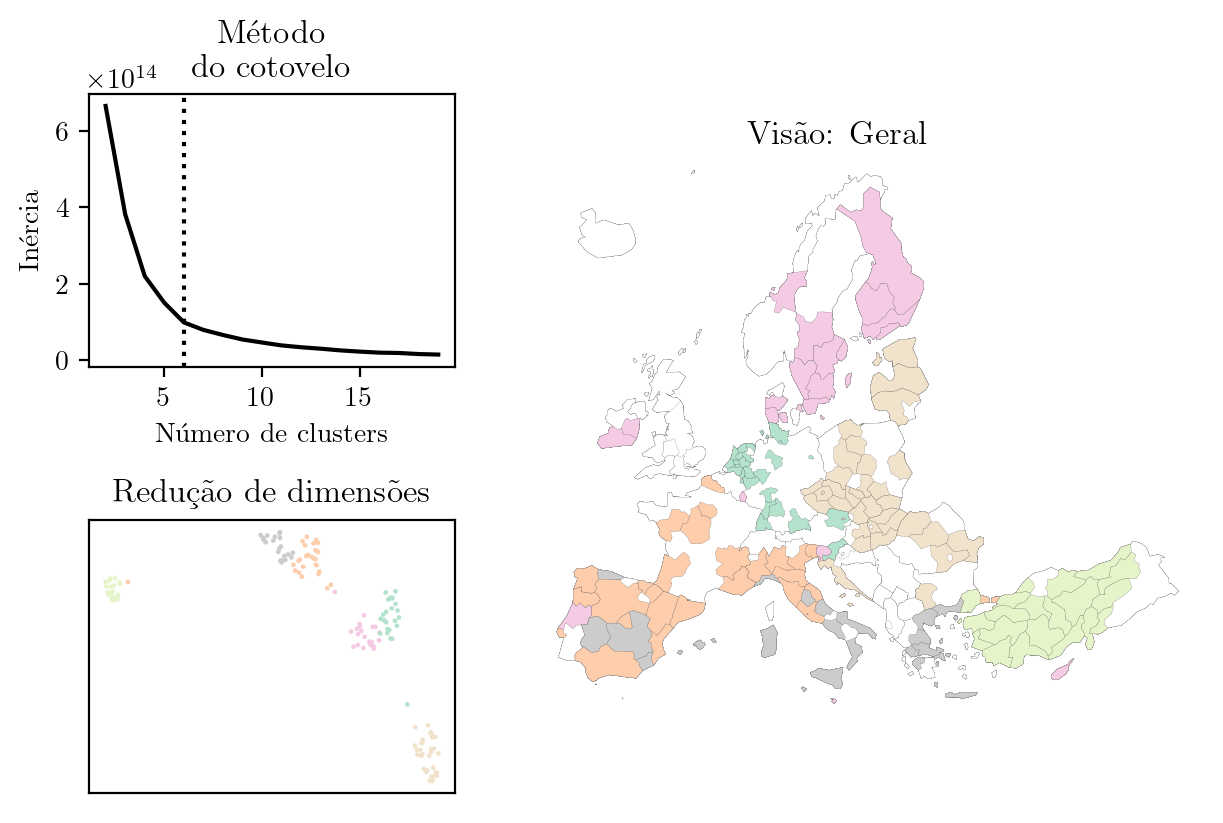

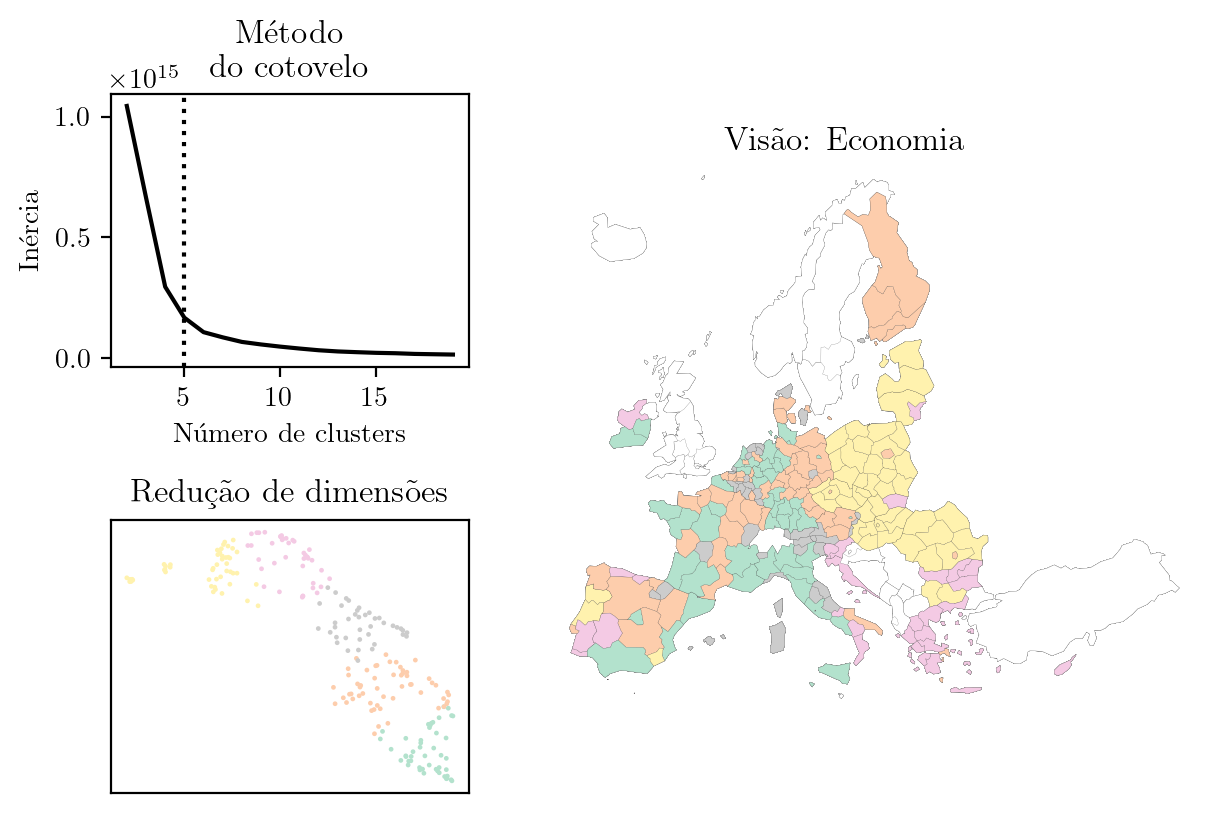

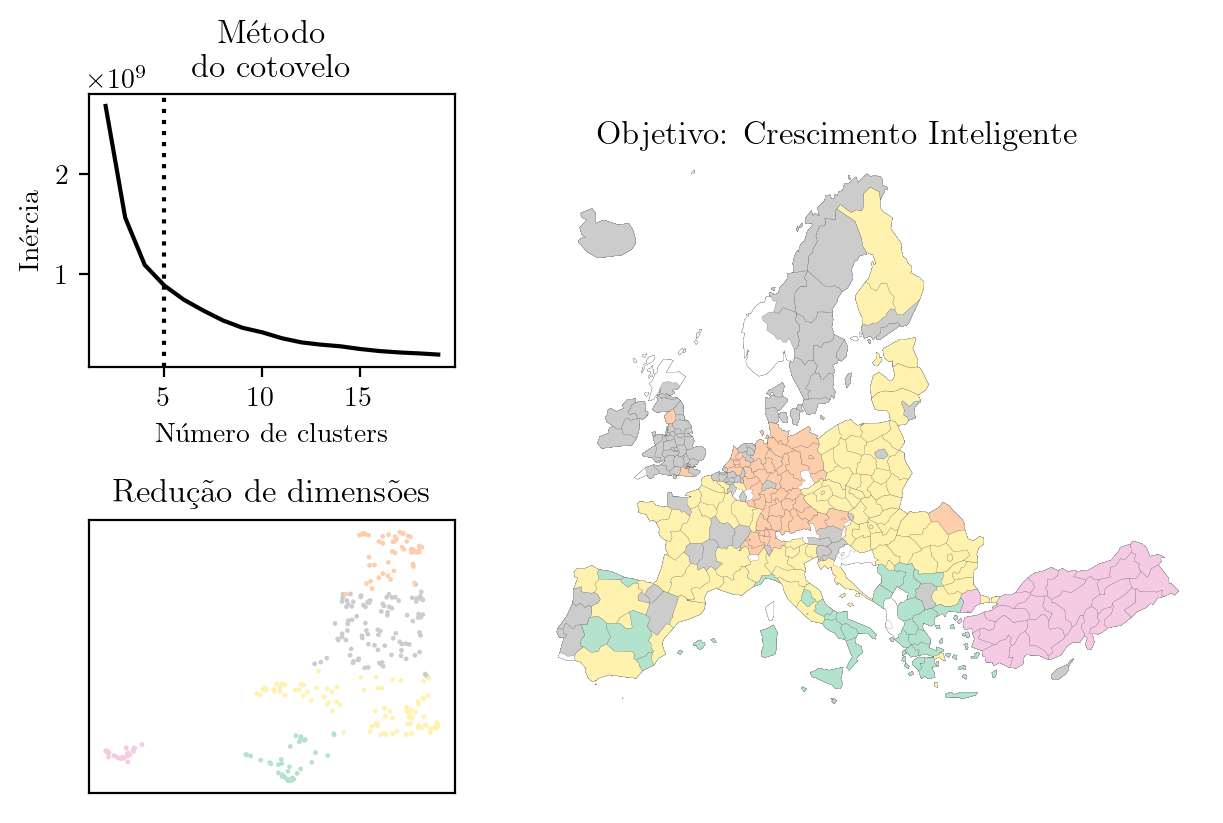

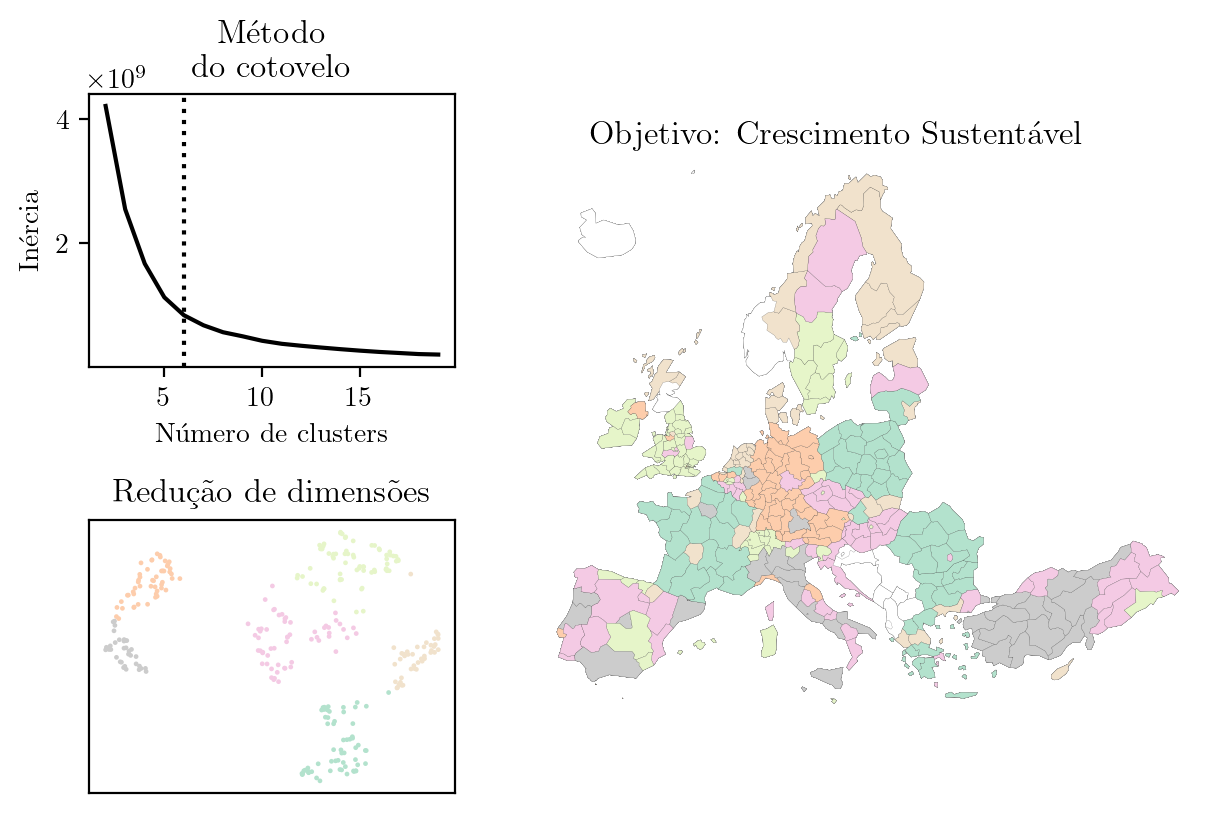

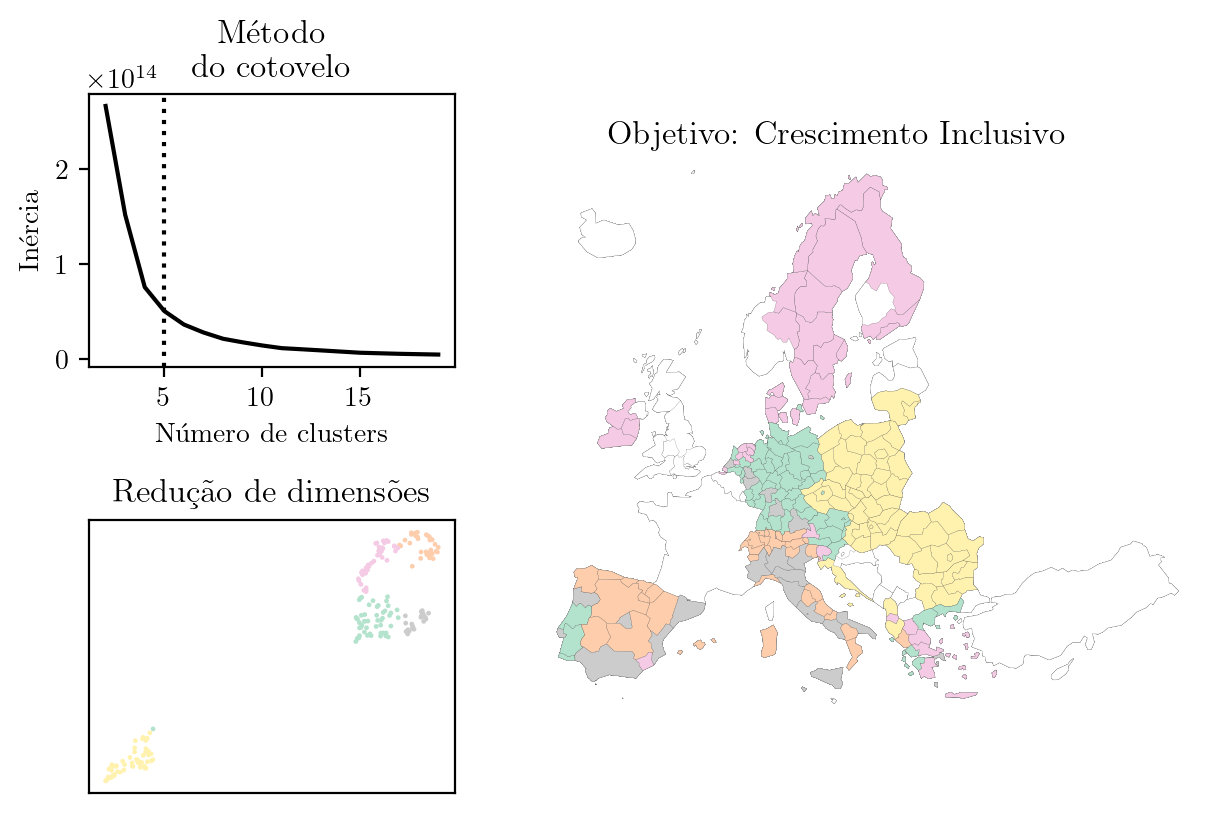

In [17]:
plotClusterEU(euro, geral[0], 'Pastel2_r', 'geral', 6, geral[1], "Visão: Geral")
plotClusterEU(euro, econ[0], 'Pastel2_r', 'econ', 5, econ[1], "Visão: Economia")
plotClusterEU(euro, smart[0], 'Pastel2_r', 'smart', 5, smart[1], "Objetivo: Crescimento Inteligente")
plotClusterEU(euro, sustainable[0], 'Pastel2_r', 'sustainable', 6, sustainable[1], "Objetivo: Crescimento Sustentável")
plotClusterEU(euro, inclusive[0], 'Pastel2_r', 'inclusive', 5, inclusive[1], "Objetivo: Crescimento Inclusivo")

# RIS

In [21]:
def treatRIS():
    ris = pd.read_excel('data/EIS_Data.xlsx')
    ris = ris[ris.Level==1]
    ris = ris.loc[~ris.iloc[:,:-1].duplicated(keep='first')]
    ris = ris.pivot(index=["Year", "Region"], columns="Indicator",values="Value")
    return ris

In [22]:
def keepPT(df): return df.loc[(df.index.str.len()>2)&(df.index.str[:2]=='PT'),]

In [23]:
ris = treatRIS()
nut2name = euro.set_index('NUTS_ID').NUTS_NAME.to_dict()
ris_results = keepPT(ris.stack().unstack(0).diff(axis=1).mean(axis=1).unstack(1)).T\
.apply(lambda s: pd.Series([s.max(),nut2name.get(s.idxmax()), s.min(),nut2name.get(s.idxmin())]), axis=1).dropna()

In [24]:
ris_results

0  \
Indicator                                                       
0 Summary Innovation Index                           2.196894   
1.1.2 Population with tertiary education (Regio...   7.187239   
1.1.3 Population involved in lifelong learning ...   1.587302   
1.2.1 International scientific co-publications ...   5.646049   
1.2.2 Scientific publications among the top 10%...  -1.353843   
1.3.2 Individuals with above basic overall digi...   5.637470   
2.1.1 R&D expenditure in the public sector (Reg...   1.006036   
2.2.1 R&D expenditure in the business sector (R...   2.249719   
2.2.2 Non-R&D innovation expenditures (Regional)    -3.449235   
2.2.3 Innovation expenditures per person employ...  -0.269048   
3.1.1 SMEs introducing product innovations (Reg...   3.685370   
3.1.2 SMEs introducing business process innovat...  -5.489521   
3.2.1 Innovative SMEs collaborating with others...  10.374355   
3.2.2 Public-private co-publications (Regional)      7.528816   
3.3.1 PCT patent applications (Regional)             3.759642   
3.3.2 Trademark applications (Regional)             10.030949   
3.3.3 Design applications (Regional)                 3.618362   
4.1.1 Employment in knowledge-intensive activit...   4.255864   
4.1.2 Employment in innovative enterprises (Reg...  -4.787268   
4.2.3 Sales of new-to-market and new-to-firm in...  16.242349   
4.3.2 Air emissions by fine particulates (Regio...   6.044599   

                                                                               1  \
Indicator                                                                          
0 Summary Innovation Index                                                 Norte   
1.1.2 Population with tertiary education (Regio...    Região Autónoma da Madeira   
1.1.3 Population involved in lifelong learning ...  Área Metropolitana de Lisboa   
1.2.1 International scientific co-publications ...                         Norte   
1.2.2 Scientific publications among the top 10%...                      Alentejo   
1.3.2 Individuals with above basic overall digi...                      Alentejo   
2.1.1 R&D expenditure in the public sector (Reg...                      Alentejo   
2.2.1 R&D expenditure in the business sector (R...                      Alentejo   
2.2.2 Non-R&D innovation expenditures (Regional)    Área Metropolitana de Lisboa   
2.2.3 Innovation expenditures per person employ...    Região Autónoma dos Açores   
3.1.1 SMEs introducing product innovations (Reg...    Região Autónoma da Madeira   
3.1.2 SMEs introducing business process innovat...                         Norte   
3.2.1 Innovative SMEs collaborating with others...    Região Autónoma dos Açores   
3.2.2 Public-private co-publications (Regional)                          Algarve   
3.3.1 PCT patent applications (Regional)                                 Algarve   
3.3.2 Trademark applications (Regional)                                    Norte   
3.3.3 Design applications (Regional)                  Região Autónoma dos Açores   
4.1.1 Employment in knowledge-intensive activit...                         Norte   
4.1.2 Employment in innovative enterprises (Reg...    Região Autónoma dos Açores   
4.2.3 Sales of new-to-market and new-to-firm in...    Região Autónoma dos Açores   
4.3.2 Air emissions by fine particulates (Regio...                       Algarve   

                                                            2  \
Indicator                                                       
0 Summary Innovation Index                           0.076187   
1.1.2 Population with tertiary education (Regio...   0.414648   
1.1.3 Population involved in lifelong learning ...  -4.184704   
1.2.1 International scientific co-publications ...   3.717529   
1.2.2 Scientific publications among the top 10%... -17.366884   
1.3.2 Individuals with above basic overall digi...   1.246858   
2.1.1 R&D expenditure in the public sector (Reg...  -1.408451   
2.2.1 R&D expenditure in the business sector (

In [25]:
"Best NUTS (-1 algarve)", ris_results[1].value_counts(), "","Worse NUTS", ris_results[3].value_counts()

('Best NUTS (-1 algarve)',
 Norte                           5
 Região Autónoma dos Açores      5
 Alentejo                        4
 Algarve                         3
 Região Autónoma da Madeira      2
 Área Metropolitana de Lisboa    2
 Name: 1, dtype: int64,
 '',
 'Worse NUTS',
 Região Autónoma da Madeira      7
 Região Autónoma dos Açores      4
 Área Metropolitana de Lisboa    4
 Centro (PT)                     3
 Algarve                         2
 Alentejo                        1
 Name: 3, dtype: int64)

In [26]:
def getMargins(df, n): return pd.concat([df.iloc[:5], df.iloc[-5:]])

In [27]:
getMargins(keepPT(ris.stack().unstack(0).diff(axis=1).mean(axis=1).unstack(1)).T.mean(axis=1).dropna().sort_values(ascending=False),5)

Indicator
3.3.2 Trademark applications (Regional)                                   6.054434
1.2.1 International scientific co-publications (Regional)                 4.371428
3.2.2 Public-private co-publications (Regional)                           4.176123
1.1.2 Population with tertiary education (Regional)                       4.087249
4.2.3 Sales of new-to-market and new-to-firm innovations (Regional)       3.572408
3.3.3 Design applications (Regional)                                     -0.593542
1.2.2 Scientific publications among the top 10% most cited (Regional)    -5.346241
4.1.2 Employment in innovative enterprises (Regional)                    -6.326470
2.2.2 Non-R&D innovation expenditures (Regional)                         -6.756690
3.1.2 SMEs introducing business process innovations (Regional)          -10.657488
dtype: float64